In [ ]:
# Standard imports
import pandas as pd
import numpy as np
import time
import pickle
import math

from datetime import datetime
from tqdm import tqdm
tqdm.pandas()

# Functions (defs) from other notebooks
import ipynb.fs.defs.CreateCollocatedDataFrame as ccdf

# Machine Learning
import h2o
from h2o.automl import H2OAutoML, get_leaderboard
import catboost as cb
from catboost import CatBoostRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance

# Plotting
from matplotlib import pyplot as plt
from calendar import month_abbr

In [224]:
# Set data frame options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [225]:
# Set boolean parameters
load_preprocessed_df = True
save_processed_file = True
save_h2o_models = True

In [226]:
if load_preprocessed_df:
    # india_df = pd.read_csv('/Users/madsrindal/Desktop/standard_processed_ml_df_india.csv')
    iran_df = pd.read_csv('/Users/madsrindal/Desktop/standard_processed_ml_df_iran.csv')
else:
    # india_df = pd.read_csv('/Users/madsrindal/Desktop/Intervals/24-80-19-85/InterpolatedDF-withCYGNSSQFs-[24-80-19-85].csv')
    iran_df = pd.read_csv('/Users/madsrindal/Desktop/Intervals/31-59-26-64/BestInterpolatedDF-Iran-[27.5, 59, 27, 60].csv')
    iran_df = iran_df.append(pd.read_csv('/Users/madsrindal/Desktop/Intervals/31-59-26-64/WorstInterpolatedDF-Iran-[31, 59, 30, 60].csv'), ignore_index=True)
    
    
     # FILTER SMAP NAN VALUES
    print('Filtering SMAP NaN values...')
    print('-'*60)
    before = iran_df.shape[0]
    iran_df = ccdf.filter_nan_smap_sm(iran_df)
    iran_df = ccdf.filter_nan_smap_vo(iran_df)
    iran_df = ccdf.filter_nan_smap_sr(iran_df)
    after = iran_df.shape[0]
    print('Removed ' + str(before-after) + ' rows of SMAP NaN values')
    print('-'*60)

    ## FILTER QUALITY FLAGS
    print('\nFiltering quality flags...')
    print('-'*40)
    before = iran_df.shape[0]
    iran_df = ccdf.filter_cygnss_qf(iran_df)
    after = iran_df.shape[0]
    print('Removed ' + str(before-after) + ' rows due to CYGNSS QFs')
    print('-'*40)

    ## COMPUTE BLOCK_CODE
    print('\nComputing block codes...')
    iran_df = ccdf.compute_block_code(iran_df)

    ## SCALE SURFACE REFLECTIVITY VALUES (REMOVE THE MIN VALUE FROM ALL OTHER VALUES)
    print('\nScaling surface reflectivity values...')
    iran_df = ccdf.scale_sr_values(iran_df)

    ## COMPUTE DAILY HOUR (0-23)
    print('\nComputing daily hour from 0-23...')
    iran_df = ccdf.compute_daily_hour_column(iran_df)

    ## COMPUTE TIME OF DAY (morning/day/afternoon/night)
    print('\nComputing time of day (morning/day/afternoon/night)...')
    iran_df = ccdf.compute_time_of_day(iran_df)
    
    if save_processed_file:
        iran_df.to_csv('/Users/madsrindal/Desktop/standard_processed_ml_df_iran.csv', index=False)

    print('##### PREPROCESSING DONE #####')
    

In [227]:
#print('India Data Frame Shape: ', india_df.shape)
print('Iran Data Frame Shape: ', iran_df.shape)

Iran Data Frame Shape:  (312225, 27)


In [228]:
iran_df.head()

,ddm_channel,spacecraft_num,day_of_year,sp_lat,sp_lon,ddm_timestamp_utc,ddm_snr,gps_tx_power_db_w,gps_ant_gain_db_i,rx_to_sp_range,tx_to_sp_range,sp_rx_gain,track_id,prn_code,sp_inc_angle,quality_flags,quality_flags_2,sr,unique_track_id,year,hours_after_jan_2019,smap_sm,smap_vo,smap_surface_roughness,block_code,daily_hour,time_of_day
0,0,1,1,27.484758,59.913864,25736.0,7.831942,16.353001,14.574718,581784,20453321,8.155090,248,31,24.288321,269313,0,11.753517,2480311.001,2019,7.0,0.066348,0.000111,0.513287,IIR-M,7,M
1,0,1,1,27.461369,59.968231,25737.0,7.731307,16.353001,14.571918,581627,20452021,8.186412,248,31,24.251165,269313,0,11.623759,2480311.001,2019,7.0,0.064490,0.000047,0.475197,IIR-M,7,M
2,0,2,1,27.458376,59.003445,23523.0,10.736886,14.250000,14.610838,576187,20483160,4.032608,255,18,23.723064,408577,8,20.857830,2550182.001,2019,7.0,0.094935,0.016708,0.502860,III,7,M
3,0,2,1,27.436745,59.059109,23524.0,8.620946,14.250000,14.613836,576420,20485223,3.983904,255,18,23.780615,400385,8,18.788542,2550182.001,2019,7.0,0.096425,0.027455,0.490655,III,7,M
4,0,2,1,27.415066,59.114754,23525.0,9.206494,14.250000,14.616858,576653,20487293,3.934361,255,18,23.838194,400385,8,19.421562,2550182.001,2019,7.0,0.097574,0.037193,0.481557,III,7,M


In [229]:
print(iran_df['sp_lat'].min())
print(iran_df['sp_lat'].max())

print(iran_df['sp_lon'].min())
print(iran_df['sp_lon'].max())

27.00003433227539
30.9660873413086
59.000030517578125
59.99999237060547


In [230]:
def filter_smap_day(df, start_hour, end_hour):
    filtered_df = df[df['time'] >= start_hour]
    filtered_df = filtered_df[filtered_df['time'] < end_hour]
    return filtered_df


def split_df_by_date(df, day, month, year):
    day_of_year = datetime(year, month, day).timetuple().tm_yday
    
    test_df = df[(df['day_of_year'] >= day_of_year) & (df['year'] == year)]
    test_df = test_df.append(test_df[test_df['year'] > year], ignore_index=True)
    
    training_df = pd.concat([df, test_df, test_df]).drop_duplicates(keep=False)
    
    return training_df, test_df


def split_smap_df_by_date(df, day, month, year):
    day_of_year = datetime(year, month, day).timetuple().tm_yday
    
    test_df = df[(df['time'] >= day_of_year) & (df['year'] == year)]
    test_df = test_df.append(test_df[test_df['year'] > year], ignore_index=True)
    
    training_df = pd.concat([df, test_df, test_df]).drop_duplicates(keep=False)
    
    return training_df, test_df


def filter_location_smap(df, location):
    filtered_df = df[df.lat < location[0]]
    filtered_df = filtered_df[filtered_df.lat > location[2]]
    filtered_df = filtered_df[filtered_df.long < location[3]]
    filtered_df = filtered_df[filtered_df.long > location[1]]
    return filtered_df


def round_nearest(x, a):
    return round(x / a) * a


def get_dem_parameters(lat, long, dem_df):
    lst = list(dem_df['rounded_long'].unique())[:2]
    grid_box_size = round(lst[1] - lst[0], 5)
    rounded_lat = round(round_nearest(lat, grid_box_size), 5)
    rounded_long = round(round_nearest(long, grid_box_size), 5)
    
    tmp_df = dem_df[(dem_df['rounded_lat'] == rounded_lat) & (dem_df['rounded_long'] == rounded_long)]
    row = tmp_df.iloc[0]
    return row['delta_angle'], row['rmse_distance']


def set_dem_parameters(cygnss_df, dem_df):
    cygnss_df['delta_angle'] = cygnss_df.progress_apply(lambda row: get_dem_parameters(row.sp_lat, row.sp_lon, dem_df)[0], axis=1)
    cygnss_df['rmse_distance'] = cygnss_df.progress_apply(lambda row: get_dem_parameters(row.sp_lat, row.sp_lon, dem_df)[1], axis=1)
    return cygnss_df


In [231]:
# Set desired pixel location
# INDIA
# pixel_loc = [21.5, 81.5, 21, 82] # Best cell
# pixel_loc = [20, 83.5, 19.5, 84] # Worst cell

# IRAN
# pixel_loc = [27.5, 59, 27, 59.5] # Best cell
pixel_loc = [30.5, 59.5, 30, 60] # Worst cell

#india_df = ccdf.filter_location(india_df, pixel_loc)
iran_df = ccdf.filter_location(iran_df, pixel_loc)

In [235]:
iran_df.head()

,ddm_channel,spacecraft_num,day_of_year,sp_lat,sp_lon,ddm_timestamp_utc,ddm_snr,gps_tx_power_db_w,gps_ant_gain_db_i,rx_to_sp_range,tx_to_sp_range,sp_rx_gain,track_id,prn_code,sp_inc_angle,quality_flags,quality_flags_2,sr,unique_track_id,year,hours_after_jan_2019,smap_sm,smap_vo,smap_surface_roughness,block_code,daily_hour,time_of_day
98290,0,3,1,30.154051,59.552689,24885.0,2.575393,13.199,16.355528,729327,21957888,8.119196,251,14,45.585567,400385,0,8.562784,2510143.001,2019,7.0,0.050941,0.0,0.353865,III,7,M
98291,0,3,1,30.129688,59.609154,24886.0,2.561683,13.199,16.355354,729272,21957522,8.128587,251,14,45.580379,269313,0,8.539696,2510143.001,2019,7.0,0.052781,0.0,0.374770,III,7,M
98292,0,3,1,30.105312,59.665569,24887.0,2.540749,13.199,16.355185,729217,21957162,8.137814,251,14,45.575256,269313,0,8.509545,2510143.001,2019,7.0,0.055685,0.0,0.397578,III,7,M
98293,0,3,1,30.080902,59.721947,24888.0,2.577430,13.199,16.355017,729156,21956806,8.147655,251,14,45.570221,269313,0,8.536394,2510143.001,2019,7.0,0.060511,0.0,0.434133,III,7,M
98294,0,3,1,30.056448,59.778320,24889.0,2.254301,13.199,16.354851,729097,21956456,8.156783,251,14,45.565266,400385,0,8.204145,2510143.001,2019,7.0,0.066037,0.0,0.480588,III,7,M


In [237]:
# dem_df_india = pd.read_csv('/Users/madsrindal/Desktop/DEM LUTs/LUT_India_BestCorrCell.csv')
# dem_df_india = pd.read_csv('/Users/madsrindal/Desktop/DEM LUTs/LUT_India_WorstCorrCell.csv')

# dem_df_iran = pd.read_csv('/Users/madsrindal/Desktop/DEM LUTs/LUT_Iran_BestCorrCell.csv')
dem_df_iran = pd.read_csv('/Users/madsrindal/Desktop/DEM LUTs/LUT_Iran_WorstCorrCell.csv')

In [238]:
dem_df_iran.head()

,rounded_lat,rounded_long,plane_coeff_a,plane_coeff_b,plane_coeff_c,plane_coeff_d,center_point_geodetic,center_point_ecef,delta_angle,rmse_distance
0,30.5,59.50,1.507822e+25,2.215297e+25,1.468083e+25,-1.943558e+32,"[30.505, 59.505, 922.0956790123457]","[2791476.9929899713, 4739933.358419704, 321920...",3.639941,12.689055
1,30.5,59.51,1.204156e+27,2.787260e+27,1.413765e+27,-2.112433e+34,"[30.505, 59.515, 891.5185185185185]","[2790636.310980244, 4740397.787905345, 3219184...",8.278426,16.262404
2,30.5,59.52,9.056712e+26,1.060305e+27,1.022455e+27,-1.084477e+34,"[30.505, 59.525000000000006, 836.7191358024692]","[2789784.9676628257, 4740844.081935132, 321915...",10.248030,22.858230
3,30.5,59.53,9.267130e+26,1.380317e+27,9.598438e+26,-1.221930e+34,"[30.505, 59.535000000000004, 964.2654320987655]","[2789013.2083245567, 4741425.639225563, 321922...",2.968585,16.390049
4,30.5,59.54,8.415463e+26,1.515237e+27,1.143813e+27,-1.321360e+34,"[30.505, 59.545, 971.3302469135803]","[2788188.7161974185, 4741917.588748342, 321922...",3.308221,17.958665


In [239]:
# india_df = set_dem_parameters(india_df, dem_df_india)
iran_df = set_dem_parameters(iran_df, dem_df_iran)

100%|██████████| 54684/54684 [00:47<00:00, 1163.20it/s]


In [240]:
iran_df.head()

,ddm_channel,spacecraft_num,day_of_year,sp_lat,sp_lon,ddm_timestamp_utc,ddm_snr,gps_tx_power_db_w,gps_ant_gain_db_i,rx_to_sp_range,tx_to_sp_range,sp_rx_gain,track_id,prn_code,sp_inc_angle,quality_flags,quality_flags_2,sr,unique_track_id,year,hours_after_jan_2019,smap_sm,smap_vo,smap_surface_roughness,block_code,daily_hour,time_of_day,delta_angle,rmse_distance
98290,0,3,1,30.154051,59.552689,24885.0,2.575393,13.199,16.355528,729327,21957888,8.119196,251,14,45.585567,400385,0,8.562784,2510143.001,2019,7.0,0.050941,0.0,0.353865,III,7,M,9.119463,26.021537
98291,0,3,1,30.129688,59.609154,24886.0,2.561683,13.199,16.355354,729272,21957522,8.128587,251,14,45.580379,269313,0,8.539696,2510143.001,2019,7.0,0.052781,0.0,0.374770,III,7,M,5.174826,13.443188
98292,0,3,1,30.105312,59.665569,24887.0,2.540749,13.199,16.355185,729217,21957162,8.137814,251,14,45.575256,269313,0,8.509545,2510143.001,2019,7.0,0.055685,0.0,0.397578,III,7,M,2.560986,9.536224
98293,0,3,1,30.080902,59.721947,24888.0,2.577430,13.199,16.355017,729156,21956806,8.147655,251,14,45.570221,269313,0,8.536394,2510143.001,2019,7.0,0.060511,0.0,0.434133,III,7,M,4.086495,12.183342
98294,0,3,1,30.056448,59.778320,24889.0,2.254301,13.199,16.354851,729097,21956456,8.156783,251,14,45.565266,400385,0,8.204145,2510143.001,2019,7.0,0.066037,0.0,0.480588,III,7,M,1.055435,1.488626


In [241]:
# Select ML features
all_features = ['sr', 'smap_sm', 'day_of_year', 'sp_inc_angle', 'smap_vo', 'smap_surface_roughness', 'block_code', 'time_of_day', 'delta_angle', 'rmse_distance']
cat_features = ['day_of_year', 'block_code', 'time_of_day']


In [242]:
# Create train/test split in dataset.
# The value on format [day, month, year] indicates test data from provided date 
data_split_date = [1, 7, 2021]

In [275]:
ml_df = iran_df.copy()
print('The shape of the pixel data frame: ', ml_df.shape)

# ml_features = ['sr', 'smap_sm']
# ml_features = ['sr', 'smap_sm', 'day_of_year']
# ml_features = ['sr', 'smap_sm', 'day_of_year', 'sp_inc_angle']
# ml_features = ['sr', 'smap_sm', 'day_of_year', 'sp_inc_angle', 'smap_vo', 'smap_surface_roughness']
# ml_features = ['sr', 'smap_sm', 'day_of_year', 'sp_inc_angle', 'smap_vo', 'smap_surface_roughness', 'block_code', 'time_of_day']
ml_features = ['sr', 'smap_sm', 'day_of_year', 'sp_inc_angle', 'smap_vo', 'smap_surface_roughness', 'block_code', 'time_of_day', 'delta_angle', 'rmse_distance']

ml_df_train, ml_df_test = split_df_by_date(ml_df, data_split_date[0], data_split_date[1], data_split_date[2])
ml_df_train = ccdf.select_df_features(ml_df_train, ml_features)
ml_df_test = ccdf.select_df_features(ml_df_test, ml_features)
print('The shape of the training data: ', ml_df_train.shape)
print('The shape of the testing data: ', ml_df_test.shape)


The shape of the pixel data frame:  (54684, 29)
The shape of the training data:  (44541, 10)
The shape of the testing data:  (10143, 10)


## AutoML

In [278]:
try:
    h2o.shutdown()
except:
    pass

/Users/madsrindal/opt/miniconda3/envs/SemesterProject/lib/python3.7/site-packages/ipykernel_launcher.py:2: H2ODeprecationWarning: Deprecated, use ``h2o.cluster().shutdown()``.
  


In [279]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "15" 2020-09-15; OpenJDK Runtime Environment (build 15+36-1562); OpenJDK 64-Bit Server VM (build 15+36-1562, mixed mode, sharing)
  Starting server from /Users/madsrindal/opt/miniconda3/envs/SemesterProject/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/gn/4ykvjj5x03v48y9sy_v11zlh0000gn/T/tmpzm7e4rhr
  JVM stdout: /var/folders/gn/4ykvjj5x03v48y9sy_v11zlh0000gn/T/tmpzm7e4rhr/h2o_madsrindal_started_from_python.out
  JVM stderr: /var/folders/gn/4ykvjj5x03v48y9sy_v11zlh0000gn/T/tmpzm7e4rhr/h2o_madsrindal_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Oslo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.1
H2O_cluster_version_age:,1 month and 15 days
H2O_cluster_name:,H2O_from_python_madsrindal_p7890c
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [280]:
train_h2o = h2o.H2OFrame(ml_df_train)
test_h2o = h2o.H2OFrame(ml_df_test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [281]:
y = 'smap_sm'
x = train_h2o.columns
x.remove(y)

train_h2o['day_of_year'] = train_h2o['day_of_year'].asfactor()
train_h2o['block_code'] = train_h2o['block_code'].asfactor()
train_h2o['time_of_day'] = train_h2o['time_of_day'].asfactor()

test_h2o['day_of_year'] = test_h2o['day_of_year'].asfactor()
test_h2o['block_code'] = test_h2o['block_code'].asfactor()
test_h2o['time_of_day'] = test_h2o['time_of_day'].asfactor()

In [282]:
start_time = time.time()
aml = H2OAutoML(balance_classes=False, max_models = 15, seed = 1, include_algos = ["xgboost", "GBM", "DRF", "StackedEnsemble", "DeepLearning"])
aml.train(x = x, y = y, training_frame = train_h2o)
print('Finished the training process in a total of ' + str(time.time()-start_time) + ' seconds...\n')
    

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
Finished the training process in a total of 4360.6839191913605 seconds...



In [283]:
#lb = aml.leaderboard
#lb.head(rows=lb.nrows)

lb = get_leaderboard(aml, extra_columns = 'algo')
lb.head(25)

model_id,rmse,mse,mae,rmsle,mean_residual_deviance,algo
StackedEnsemble_AllModels_1_AutoML_1_20220529_141312,0.00288452,8.32044e-06,0.00122087,0.00257504,8.32044e-06,StackedEnsemble
StackedEnsemble_BestOfFamily_1_AutoML_1_20220529_141312,0.00309408,9.5733e-06,0.00133114,0.00276543,9.5733e-06,StackedEnsemble
GBM_2_AutoML_1_20220529_141312,0.0031883,1.01652e-05,0.00142355,0.00285352,1.01652e-05,GBM
GBM_3_AutoML_1_20220529_141312,0.00326029,1.06295e-05,0.00152502,0.00291588,1.06295e-05,GBM
GBM_5_AutoML_1_20220529_141312,0.00334423,1.11839e-05,0.00151386,0.0029883,1.11839e-05,GBM
GBM_4_AutoML_1_20220529_141312,0.00335934,1.12852e-05,0.00160191,0.00300856,1.12852e-05,GBM
GBM_1_AutoML_1_20220529_141312,0.00351184,1.2333e-05,0.00167582,0.00314614,1.2333e-05,GBM
XGBoost_3_AutoML_1_20220529_141312,0.00383045,1.46724e-05,0.00172186,0.00343608,1.46724e-05,XGBoost
XGBoost_2_AutoML_1_20220529_141312,0.00423275,1.79162e-05,0.00188007,0.00376952,1.79162e-05,XGBoost
XGBoost_1_AutoML_1_20220529_141312,0.00475644,2.26238e-05,0.00244952,0.00428145,2.26238e-05,XGBoost


In [284]:
model1 = aml.get_best_model(algorithm="xgboost", criterion="rmse")
model2 = aml.get_best_model(algorithm="GBM", criterion="rmse")
model3 = aml.get_best_model(algorithm="DRF", criterion="rmse")
model4 = aml.get_best_model(algorithm="StackedEnsemble", criterion="rmse")
model5 = aml.get_best_model(algorithm="DeepLearning", criterion="rmse")

In [285]:
print(str(ml_features))

['sr', 'smap_sm', 'day_of_year', 'sp_inc_angle', 'smap_vo', 'smap_surface_roughness', 'block_code', 'time_of_day', 'delta_angle', 'rmse_distance']


In [286]:
if save_h2o_models:
    
    model_name1 = 'xgboost_rmse_' + str(ml_features)
    model_name2 = 'GBM_rmse_' + str(ml_features)
    model_name3 = 'DRF_rmse_' + str(ml_features)
    model_name4 = 'StackedEnsemble_rmse_' + str(ml_features)
    model_name5 = 'DeepLearning_rmse_' + str(ml_features)
    
    model_path1 = h2o.save_model(model=model1, path="/tmp/mymodel", force=True)
    model_path2 = h2o.save_model(model=model2, path="/tmp/mymodel", force=True)
    model_path3 = h2o.save_model(model=model3, path="/tmp/mymodel", force=True)
    model_path4 = h2o.save_model(model=model4, path="/tmp/mymodel", force=True)
    model_path5 = h2o.save_model(model=model5, path="/tmp/mymodel", force=True)

    model1_local1 = h2o.download_model(model1, path="/Users/madsrindal/Desktop/AutoML - Models/Iran/WorstCell/" + str(ml_features))
    model1_local2 = h2o.download_model(model2, path="/Users/madsrindal/Desktop/AutoML - Models/Iran/WorstCell/" + str(ml_features))
    model1_local3 = h2o.download_model(model3, path="/Users/madsrindal/Desktop/AutoML - Models/Iran/WorstCell/" + str(ml_features))
    model1_local4 = h2o.download_model(model4, path="/Users/madsrindal/Desktop/AutoML - Models/Iran/WorstCell/" + str(ml_features))
    model1_local5 = h2o.download_model(model5, path="/Users/madsrindal/Desktop/AutoML - Models/Iran/WorstCell/" + str(ml_features))
    

In [287]:
preds1 = model1.predict(test_h2o)
preds2 = model2.predict(test_h2o)
preds3 = model3.predict(test_h2o)
preds4 = model4.predict(test_h2o)
preds5 = model5.predict(test_h2o)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


In [288]:
predictions1 = h2o.as_list(preds1)
predictions2 = h2o.as_list(preds2)
predictions3 = h2o.as_list(preds3)
predictions4 = h2o.as_list(preds4)
predictions5 = h2o.as_list(preds5)

In [289]:
rmse_xgboost = mean_squared_error(h2o.as_list(test_h2o['smap_sm'])['smap_sm'], predictions1['predict'], squared=False)
rmse_gbm = mean_squared_error(h2o.as_list(test_h2o['smap_sm'])['smap_sm'], predictions2['predict'], squared=False)
rmse_drf = mean_squared_error(h2o.as_list(test_h2o['smap_sm'])['smap_sm'], predictions3['predict'], squared=False)
rmse_stack = mean_squared_error(h2o.as_list(test_h2o['smap_sm'])['smap_sm'], predictions4['predict'], squared=False)
rmse_dl = mean_squared_error(h2o.as_list(test_h2o['smap_sm'])['smap_sm'], predictions5['predict'], squared=False)

In [92]:
## 4 PARAMS ##
print('RMSE XGBOOST: ', rmse_xgboost)
print('RMSE GBM: ', rmse_gbm)
print('RMSE DRF: ', rmse_drf)
print('RMSE STACK: ', rmse_stack)
print('RMSE DEEP LEARNING: ', rmse_dl)

RMSE XGBOOST:  0.0385209827728328
RMSE GBM:  0.037560583493208066
RMSE DRF:  0.04195317970263692
RMSE STACK:  0.036627096206296096
RMSE DEEP LEARNING:  0.04171533122502675


In [116]:
## 6 PARAMS ##
print('RMSE XGBOOST: ', rmse_xgboost)
print('RMSE GBM: ', rmse_gbm)
print('RMSE DRF: ', rmse_drf)
print('RMSE STACK: ', rmse_stack)
print('RMSE DEEP LEARNING: ', rmse_dl)

RMSE XGBOOST:  0.03871962824685763
RMSE GBM:  0.03271807620748693
RMSE DRF:  0.045735345252279035
RMSE STACK:  0.033012199696138646
RMSE DEEP LEARNING:  0.04471144470152807


In [256]:
## 8 PARAMS ##
print('RMSE XGBOOST: ', rmse_xgboost)
print('RMSE GBM: ', rmse_gbm)
print('RMSE DRF: ', rmse_drf)
print('RMSE STACK: ', rmse_stack)
print('RMSE DEEP LEARNING: ', rmse_dl)

RMSE XGBOOST:  0.022907351024549855
RMSE GBM:  0.027106490392945472
RMSE DRF:  0.01993790399911024
RMSE STACK:  0.02416637207143817
RMSE DEEP LEARNING:  0.021850738839074756


In [290]:
## 10 PARAMS ##
print('RMSE XGBOOST: ', rmse_xgboost)
print('RMSE GBM: ', rmse_gbm)
print('RMSE DRF: ', rmse_drf)
print('RMSE STACK: ', rmse_stack)
print('RMSE DEEP LEARNING: ', rmse_dl)

RMSE XGBOOST:  0.028393704457102348
RMSE GBM:  0.02563564643334251
RMSE DRF:  0.020558189186907102
RMSE STACK:  0.02473353124949918
RMSE DEEP LEARNING:  0.028167348833758724


In [291]:
smap_sm_list = list(h2o.as_list(test_h2o['smap_sm'])['smap_sm'])
predicted_sm_list1 = list(predictions1['predict'])
predicted_sm_list2 = list(predictions2['predict'])
predicted_sm_list3 = list(predictions3['predict'])
predicted_sm_list4 = list(predictions4['predict'])
predicted_sm_list5 = list(predictions5['predict'])

In [292]:
train, test = split_df_by_date(ml_df, data_split_date[0], data_split_date[1], data_split_date[2])

In [293]:
#test = ccdf.select_df_features(test, ['sr', 'smap_sm', 'day_of_year'])
test = ccdf.select_df_features(test, ['sr', 'smap_sm', 'day_of_year', 'block_code', 'time_of_day'])

In [294]:
sm_dict = {
    'smap_sm': smap_sm_list,
    'predicted_sm_XGBoost': predicted_sm_list1,
    'predicted_sm_GBM': predicted_sm_list2,
    'predicted_sm_DRF': predicted_sm_list3,
    'predicted_sm_StackedEnsemble': predicted_sm_list4,
    'predicted_sm_DeepLearning': predicted_sm_list5,
    'day_of_year': list(test['day_of_year'])
}

In [295]:
sm_df = pd.DataFrame(sm_dict)

In [296]:
sm_df.head()

,smap_sm,predicted_sm_XGBoost,predicted_sm_GBM,predicted_sm_DRF,predicted_sm_StackedEnsemble,predicted_sm_DeepLearning,day_of_year
0,0.055998,0.060442,0.058419,0.057535,0.058423,0.064716,182
1,0.056678,0.060714,0.058444,0.058006,0.058373,0.064906,182
2,0.057043,0.060135,0.059075,0.057535,0.058333,0.065597,182
3,0.057194,0.059569,0.057942,0.057807,0.057812,0.064663,182
4,0.057345,0.059415,0.057335,0.057807,0.057770,0.064930,182


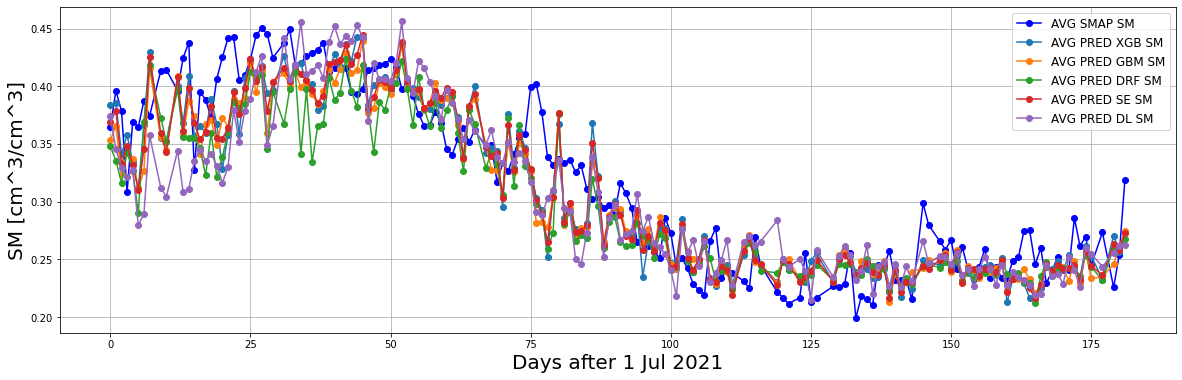

In [99]:
### MADE WITH 4 PARAMETERS ###
### BEST CELL ###

start_day = sm_df['day_of_year'].min()
end_day = 365

days = []
avg_smap_sm_values = []
avg_pred_sm_values_xgboost = []
avg_pred_sm_values_gbm = []
avg_pred_sm_values_drf = []
avg_pred_sm_values_stacked = []
avg_pred_sm_values_dl = []

for i in range(start_day, end_day+1):
    tmp_df = sm_df[sm_df['day_of_year'] == i]
    
    if tmp_df.shape[0] > 0:
        avg_smap = tmp_df['smap_sm'].mean()
        avg_pred_xgboost = tmp_df['predicted_sm_XGBoost'].mean()
        avg_pred_gbm = tmp_df['predicted_sm_GBM'].mean()
        avg_pred_drf = tmp_df['predicted_sm_DRF'].mean()
        avg_pred_stacked = tmp_df['predicted_sm_StackedEnsemble'].mean()
        avg_pred_dl = tmp_df['predicted_sm_DeepLearning'].mean()
        
        days.append(i-start_day)
        avg_smap_sm_values.append(avg_smap)
        avg_pred_sm_values_xgboost.append(avg_pred_xgboost)
        avg_pred_sm_values_gbm.append(avg_pred_gbm)
        avg_pred_sm_values_drf.append(avg_pred_drf)
        avg_pred_sm_values_stacked.append(avg_pred_stacked)
        avg_pred_sm_values_dl.append(avg_pred_dl)

        
fig = plt.figure(figsize=(20, 6))
ax = plt.axes()
ax.grid()
ax.plot(days, avg_smap_sm_values, color='blue', marker="o", label='AVG SMAP SM')
ax.plot(days, avg_pred_sm_values_xgboost, marker="o", label='AVG PRED XGB SM')
ax.plot(days, avg_pred_sm_values_gbm, marker="o", label='AVG PRED GBM SM')
ax.plot(days, avg_pred_sm_values_drf, marker="o", label='AVG PRED DRF SM')
ax.plot(days, avg_pred_sm_values_stacked, marker="o", label='AVG PRED SE SM')
ax.plot(days, avg_pred_sm_values_dl, marker="o", label='AVG PRED DL SM')
ax.set_ylabel("SM [cm^3/cm^3]", fontsize=20)

ax.set_xlabel('Days after ' + str(data_split_date[0]) + ' ' + str(month_abbr[data_split_date[1]]) + ' ' + str(data_split_date[2]), fontsize=20)
ax.set_ylabel('SM [cm^3/cm^3]', fontsize=20)
plt.legend(fontsize='large')
# plt.savefig('/Users/madsrindal/Desktop/Master Plots/AutoML/PredictedTS_4params.png', format='png')
plt.show()


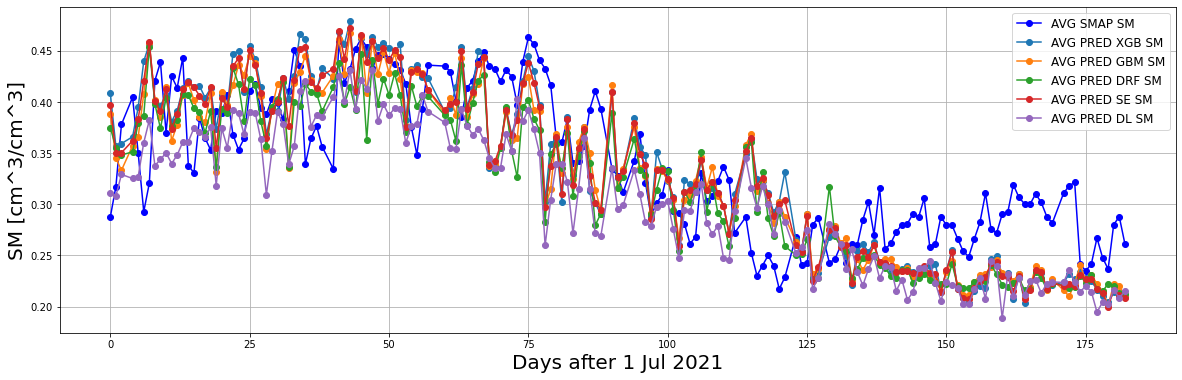

In [161]:
### MADE WITH 4 PARAMETERS ###
### WORST CELL ###

start_day = sm_df['day_of_year'].min()
end_day = 365

days = []
avg_smap_sm_values = []
avg_pred_sm_values_xgboost = []
avg_pred_sm_values_gbm = []
avg_pred_sm_values_drf = []
avg_pred_sm_values_stacked = []
avg_pred_sm_values_dl = []

for i in range(start_day, end_day+1):
    tmp_df = sm_df[sm_df['day_of_year'] == i]
    
    if tmp_df.shape[0] > 0:
        avg_smap = tmp_df['smap_sm'].mean()
        avg_pred_xgboost = tmp_df['predicted_sm_XGBoost'].mean()
        avg_pred_gbm = tmp_df['predicted_sm_GBM'].mean()
        avg_pred_drf = tmp_df['predicted_sm_DRF'].mean()
        avg_pred_stacked = tmp_df['predicted_sm_StackedEnsemble'].mean()
        avg_pred_dl = tmp_df['predicted_sm_DeepLearning'].mean()
        
        days.append(i-start_day)
        avg_smap_sm_values.append(avg_smap)
        avg_pred_sm_values_xgboost.append(avg_pred_xgboost)
        avg_pred_sm_values_gbm.append(avg_pred_gbm)
        avg_pred_sm_values_drf.append(avg_pred_drf)
        avg_pred_sm_values_stacked.append(avg_pred_stacked)
        avg_pred_sm_values_dl.append(avg_pred_dl)

        
fig = plt.figure(figsize=(20, 6))
ax = plt.axes()
ax.grid()
ax.plot(days, avg_smap_sm_values, color='blue', marker="o", label='AVG SMAP SM')
ax.plot(days, avg_pred_sm_values_xgboost, marker="o", label='AVG PRED XGB SM')
ax.plot(days, avg_pred_sm_values_gbm, marker="o", label='AVG PRED GBM SM')
ax.plot(days, avg_pred_sm_values_drf, marker="o", label='AVG PRED DRF SM')
ax.plot(days, avg_pred_sm_values_stacked, marker="o", label='AVG PRED SE SM')
ax.plot(days, avg_pred_sm_values_dl, marker="o", label='AVG PRED DL SM')
ax.set_ylabel("SM [cm^3/cm^3]", fontsize=20)

ax.set_xlabel('Days after ' + str(data_split_date[0]) + ' ' + str(month_abbr[data_split_date[1]]) + ' ' + str(data_split_date[2]), fontsize=20)
ax.set_ylabel('SM [cm^3/cm^3]', fontsize=20)
plt.legend(fontsize='large')
#plt.savefig('/Users/madsrindal/Desktop/Master Plots/AutoML/India/Worst Cell/PredictedTS_4params.png', format='png')
plt.show()


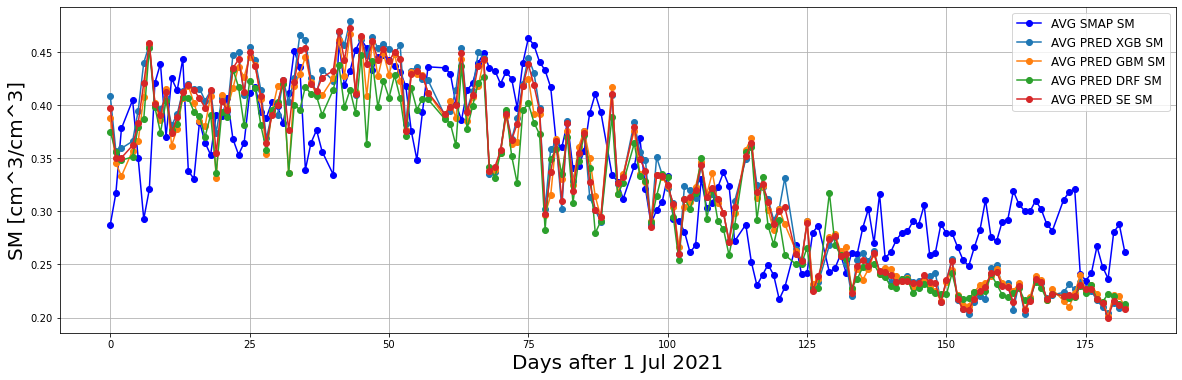

In [162]:
### MADE WITH 6 PARAMETERS ###
### BEST CELL ###

start_day = sm_df['day_of_year'].min()
end_day = 365

days = []
avg_smap_sm_values = []
avg_pred_sm_values_xgboost = []
avg_pred_sm_values_gbm = []
avg_pred_sm_values_drf = []
avg_pred_sm_values_stacked = []
#avg_pred_sm_values_dl = []

for i in range(start_day, end_day+1):
    tmp_df = sm_df[sm_df['day_of_year'] == i]
    
    if tmp_df.shape[0] > 0:
        avg_smap = tmp_df['smap_sm'].mean()
        avg_pred_xgboost = tmp_df['predicted_sm_XGBoost'].mean()
        avg_pred_gbm = tmp_df['predicted_sm_GBM'].mean()
        avg_pred_drf = tmp_df['predicted_sm_DRF'].mean()
        avg_pred_stacked = tmp_df['predicted_sm_StackedEnsemble'].mean()
        #avg_pred_dl = tmp_df['predicted_sm_DeepLearning'].mean()
        
        days.append(i-start_day)
        avg_smap_sm_values.append(avg_smap)
        avg_pred_sm_values_xgboost.append(avg_pred_xgboost)
        avg_pred_sm_values_gbm.append(avg_pred_gbm)
        avg_pred_sm_values_drf.append(avg_pred_drf)
        avg_pred_sm_values_stacked.append(avg_pred_stacked)
        #avg_pred_sm_values_dl.append(avg_pred_dl)

        
fig = plt.figure(figsize=(20, 6))
ax = plt.axes()
ax.grid()
ax.plot(days, avg_smap_sm_values, color='blue', marker="o", label='AVG SMAP SM')
ax.plot(days, avg_pred_sm_values_xgboost, marker="o", label='AVG PRED XGB SM')
ax.plot(days, avg_pred_sm_values_gbm, marker="o", label='AVG PRED GBM SM')
ax.plot(days, avg_pred_sm_values_drf, marker="o", label='AVG PRED DRF SM')
ax.plot(days, avg_pred_sm_values_stacked, marker="o", label='AVG PRED SE SM')
# ax.plot(days, avg_pred_sm_values_dl, marker="o", label='AVG PRED DL SM')
ax.set_ylabel("SM [cm^3/cm^3]", fontsize=20)
ax.set_xlabel('Days after ' + str(data_split_date[0]) + ' ' + str(month_abbr[data_split_date[1]]) + ' ' + str(data_split_date[2]), fontsize=20)
ax.set_ylabel('SM [cm^3/cm^3]', fontsize=20)
plt.legend(fontsize='large')
# plt.savefig('/Users/madsrindal/Desktop/Master Plots/AutoML/PredictedTS_6params.png', format='png')
plt.show()


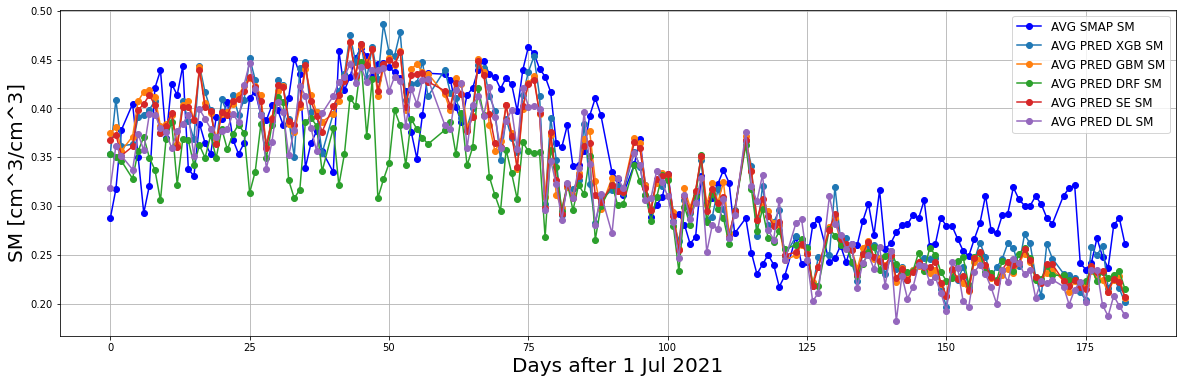

In [184]:
### MADE WITH 6 PARAMETERS ###
### WORST CELL ###

start_day = sm_df['day_of_year'].min()
end_day = 365

days = []
avg_smap_sm_values = []
avg_pred_sm_values_xgboost = []
avg_pred_sm_values_gbm = []
avg_pred_sm_values_drf = []
avg_pred_sm_values_stacked = []
avg_pred_sm_values_dl = []

for i in range(start_day, end_day+1):
    tmp_df = sm_df[sm_df['day_of_year'] == i]
    
    if tmp_df.shape[0] > 0:
        avg_smap = tmp_df['smap_sm'].mean()
        avg_pred_xgboost = tmp_df['predicted_sm_XGBoost'].mean()
        avg_pred_gbm = tmp_df['predicted_sm_GBM'].mean()
        avg_pred_drf = tmp_df['predicted_sm_DRF'].mean()
        avg_pred_stacked = tmp_df['predicted_sm_StackedEnsemble'].mean()
        avg_pred_dl = tmp_df['predicted_sm_DeepLearning'].mean()
        
        days.append(i-start_day)
        avg_smap_sm_values.append(avg_smap)
        avg_pred_sm_values_xgboost.append(avg_pred_xgboost)
        avg_pred_sm_values_gbm.append(avg_pred_gbm)
        avg_pred_sm_values_drf.append(avg_pred_drf)
        avg_pred_sm_values_stacked.append(avg_pred_stacked)
        avg_pred_sm_values_dl.append(avg_pred_dl)

        
fig = plt.figure(figsize=(20, 6))
ax = plt.axes()
ax.grid()
ax.plot(days, avg_smap_sm_values, color='blue', marker="o", label='AVG SMAP SM')
ax.plot(days, avg_pred_sm_values_xgboost, marker="o", label='AVG PRED XGB SM')
ax.plot(days, avg_pred_sm_values_gbm, marker="o", label='AVG PRED GBM SM')
ax.plot(days, avg_pred_sm_values_drf, marker="o", label='AVG PRED DRF SM')
ax.plot(days, avg_pred_sm_values_stacked, marker="o", label='AVG PRED SE SM')
ax.plot(days, avg_pred_sm_values_dl, marker="o", label='AVG PRED DL SM')
ax.set_ylabel("SM [cm^3/cm^3]", fontsize=20)

ax.set_xlabel('Days after ' + str(data_split_date[0]) + ' ' + str(month_abbr[data_split_date[1]]) + ' ' + str(data_split_date[2]), fontsize=20)
ax.set_ylabel('SM [cm^3/cm^3]', fontsize=20)
plt.legend(fontsize='large')
# plt.savefig('/Users/madsrindal/Desktop/Master Plots/AutoML/India/Worst Cell/PredictedTS_6params.png', format='png')
plt.show()


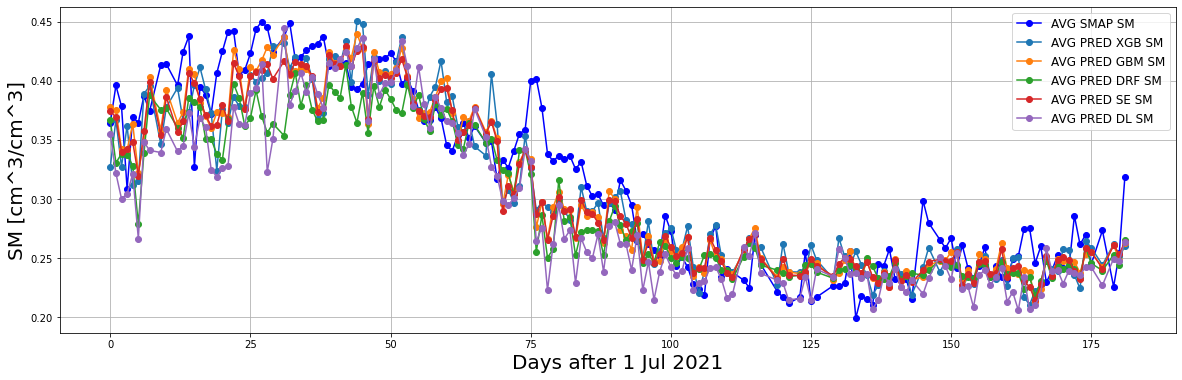

In [106]:
### MADE WITH 8 PARAMETERS ###
### BEST CELL ###

start_day = sm_df['day_of_year'].min()
end_day = 365

days = []
avg_smap_sm_values = []
avg_pred_sm_values_xgboost = []
avg_pred_sm_values_gbm = []
avg_pred_sm_values_drf = []
avg_pred_sm_values_stacked = []
avg_pred_sm_values_dl = []

for i in range(start_day, end_day+1):
    tmp_df = sm_df[sm_df['day_of_year'] == i]
    
    if tmp_df.shape[0] > 0:
        avg_smap = tmp_df['smap_sm'].mean()
        avg_pred_xgboost = tmp_df['predicted_sm_XGBoost'].mean()
        avg_pred_gbm = tmp_df['predicted_sm_GBM'].mean()
        avg_pred_drf = tmp_df['predicted_sm_DRF'].mean()
        avg_pred_stacked = tmp_df['predicted_sm_StackedEnsemble'].mean()
        avg_pred_dl = tmp_df['predicted_sm_DeepLearning'].mean()
        
        days.append(i-start_day)
        avg_smap_sm_values.append(avg_smap)
        avg_pred_sm_values_xgboost.append(avg_pred_xgboost)
        avg_pred_sm_values_gbm.append(avg_pred_gbm)
        avg_pred_sm_values_drf.append(avg_pred_drf)
        avg_pred_sm_values_stacked.append(avg_pred_stacked)
        avg_pred_sm_values_dl.append(avg_pred_dl)

        
fig = plt.figure(figsize=(20, 6))
ax = plt.axes()
ax.grid()
ax.plot(days, avg_smap_sm_values, color='blue', marker="o", label='AVG SMAP SM')
ax.plot(days, avg_pred_sm_values_xgboost, marker="o", label='AVG PRED XGB SM')
ax.plot(days, avg_pred_sm_values_gbm, marker="o", label='AVG PRED GBM SM')
ax.plot(days, avg_pred_sm_values_drf, marker="o", label='AVG PRED DRF SM')
ax.plot(days, avg_pred_sm_values_stacked, marker="o", label='AVG PRED SE SM')
ax.plot(days, avg_pred_sm_values_dl, marker="o", label='AVG PRED DL SM')
ax.set_ylabel("SM [cm^3/cm^3]", fontsize=20)
ax.set_xlabel('Days after ' + str(data_split_date[0]) + ' ' + str(month_abbr[data_split_date[1]]) + ' ' + str(data_split_date[2]), fontsize=20)
ax.set_ylabel('SM [cm^3/cm^3]', fontsize=20)
plt.legend(fontsize='large')
# plt.savefig('/Users/madsrindal/Desktop/Master Plots/AutoML/PredictedTS_8params.png', format='png')
plt.show()


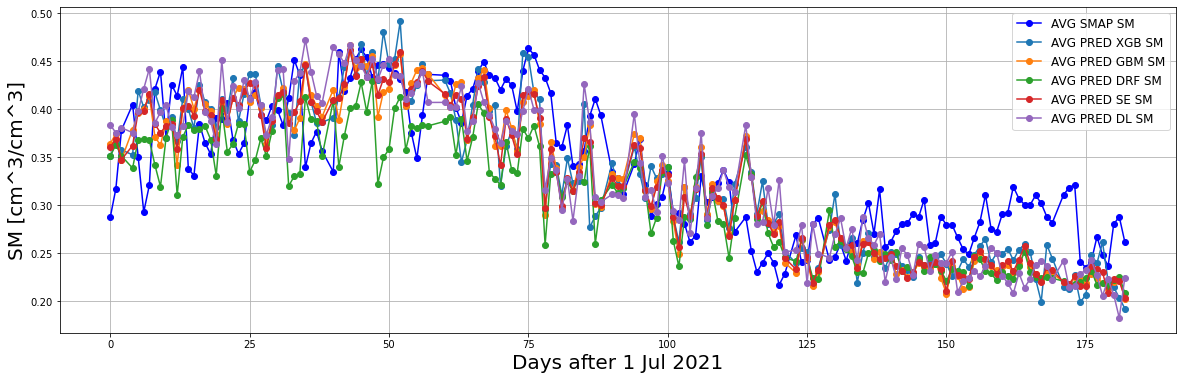

In [38]:
### MADE WITH 8 PARAMETERS ###
### WORST CELL ###

start_day = sm_df['day_of_year'].min()
end_day = 365

days = []
avg_smap_sm_values = []
avg_pred_sm_values_xgboost = []
avg_pred_sm_values_gbm = []
avg_pred_sm_values_drf = []
avg_pred_sm_values_stacked = []
avg_pred_sm_values_dl = []

for i in range(start_day, end_day+1):
    tmp_df = sm_df[sm_df['day_of_year'] == i]
    
    if tmp_df.shape[0] > 0:
        avg_smap = tmp_df['smap_sm'].mean()
        avg_pred_xgboost = tmp_df['predicted_sm_XGBoost'].mean()
        avg_pred_gbm = tmp_df['predicted_sm_GBM'].mean()
        avg_pred_drf = tmp_df['predicted_sm_DRF'].mean()
        avg_pred_stacked = tmp_df['predicted_sm_StackedEnsemble'].mean()
        avg_pred_dl = tmp_df['predicted_sm_DeepLearning'].mean()
        
        days.append(i-start_day)
        avg_smap_sm_values.append(avg_smap)
        avg_pred_sm_values_xgboost.append(avg_pred_xgboost)
        avg_pred_sm_values_gbm.append(avg_pred_gbm)
        avg_pred_sm_values_drf.append(avg_pred_drf)
        avg_pred_sm_values_stacked.append(avg_pred_stacked)
        avg_pred_sm_values_dl.append(avg_pred_dl)

        
fig = plt.figure(figsize=(20, 6))
ax = plt.axes()
ax.grid()
ax.plot(days, avg_smap_sm_values, color='blue', marker="o", label='AVG SMAP SM')
ax.plot(days, avg_pred_sm_values_xgboost, marker="o", label='AVG PRED XGB SM')
ax.plot(days, avg_pred_sm_values_gbm, marker="o", label='AVG PRED GBM SM')
ax.plot(days, avg_pred_sm_values_drf, marker="o", label='AVG PRED DRF SM')
ax.plot(days, avg_pred_sm_values_stacked, marker="o", label='AVG PRED SE SM')
ax.plot(days, avg_pred_sm_values_dl, marker="o", label='AVG PRED DL SM')
ax.set_ylabel("SM [cm^3/cm^3]", fontsize=20)
ax.set_xlabel('Days after ' + str(data_split_date[0]) + ' ' + str(month_abbr[data_split_date[1]]) + ' ' + str(data_split_date[2]), fontsize=20)
ax.set_ylabel('SM [cm^3/cm^3]', fontsize=20)
plt.legend(fontsize='large')
# plt.savefig('/Users/madsrindal/Desktop/Master Plots/AutoML/PredictedTS_8params.png', format='png')
plt.show()


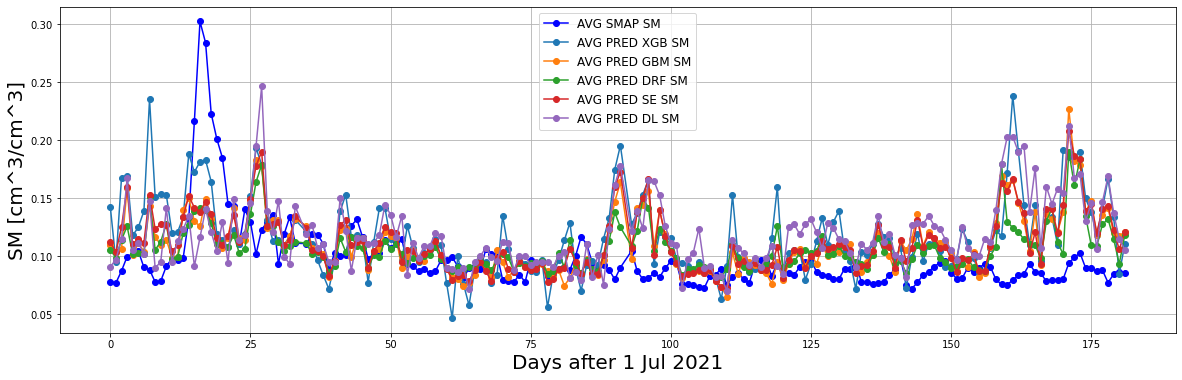

In [184]:
### MADE WITH 8 PARAMETERS ###
### IRAN ###
### BEST CELL ###

start_day = sm_df['day_of_year'].min()
end_day = 365

days = []
avg_smap_sm_values = []
avg_pred_sm_values_xgboost = []
avg_pred_sm_values_gbm = []
avg_pred_sm_values_drf = []
avg_pred_sm_values_stacked = []
avg_pred_sm_values_dl = []

for i in range(start_day, end_day+1):
    tmp_df = sm_df[sm_df['day_of_year'] == i]
    
    if tmp_df.shape[0] > 0:
        avg_smap = tmp_df['smap_sm'].mean()
        avg_pred_xgboost = tmp_df['predicted_sm_XGBoost'].mean()
        avg_pred_gbm = tmp_df['predicted_sm_GBM'].mean()
        avg_pred_drf = tmp_df['predicted_sm_DRF'].mean()
        avg_pred_stacked = tmp_df['predicted_sm_StackedEnsemble'].mean()
        avg_pred_dl = tmp_df['predicted_sm_DeepLearning'].mean()
        
        days.append(i-start_day)
        avg_smap_sm_values.append(avg_smap)
        avg_pred_sm_values_xgboost.append(avg_pred_xgboost)
        avg_pred_sm_values_gbm.append(avg_pred_gbm)
        avg_pred_sm_values_drf.append(avg_pred_drf)
        avg_pred_sm_values_stacked.append(avg_pred_stacked)
        avg_pred_sm_values_dl.append(avg_pred_dl)

        
fig = plt.figure(figsize=(20, 6))
ax = plt.axes()
ax.grid()
ax.plot(days, avg_smap_sm_values, color='blue', marker="o", label='AVG SMAP SM')
ax.plot(days, avg_pred_sm_values_xgboost, marker="o", label='AVG PRED XGB SM')
ax.plot(days, avg_pred_sm_values_gbm, marker="o", label='AVG PRED GBM SM')
ax.plot(days, avg_pred_sm_values_drf, marker="o", label='AVG PRED DRF SM')
ax.plot(days, avg_pred_sm_values_stacked, marker="o", label='AVG PRED SE SM')
ax.plot(days, avg_pred_sm_values_dl, marker="o", label='AVG PRED DL SM')
ax.set_ylabel("SM [cm^3/cm^3]", fontsize=20)
ax.set_xlabel('Days after ' + str(data_split_date[0]) + ' ' + str(month_abbr[data_split_date[1]]) + ' ' + str(data_split_date[2]), fontsize=20)
ax.set_ylabel('SM [cm^3/cm^3]', fontsize=20)
plt.legend(fontsize='large')
# plt.savefig('/Users/madsrindal/Desktop/Master Plots/AutoML/PredictedTS_8params_Iran.png', format='png')
plt.show()


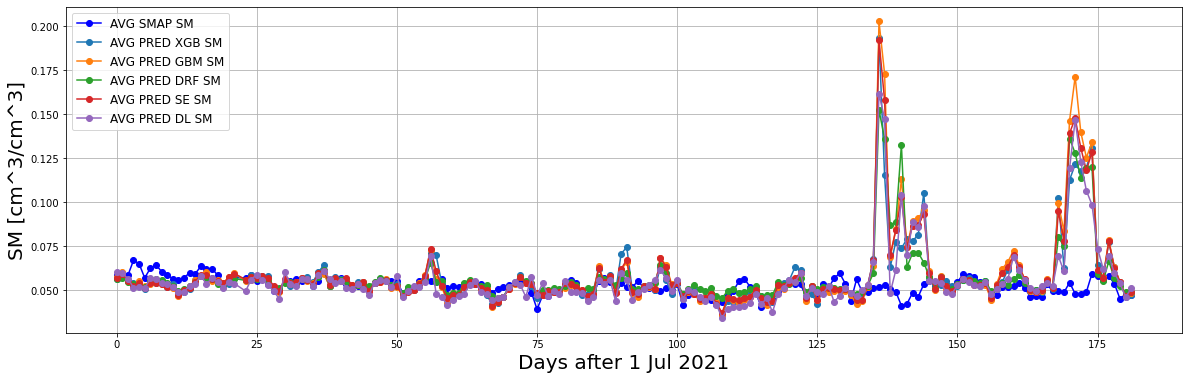

In [273]:
### MADE WITH 8 PARAMETERS ###
### IRAN ###
### WORST CELL ###

start_day = sm_df['day_of_year'].min()
end_day = 365

days = []
avg_smap_sm_values = []
avg_pred_sm_values_xgboost = []
avg_pred_sm_values_gbm = []
avg_pred_sm_values_drf = []
avg_pred_sm_values_stacked = []
avg_pred_sm_values_dl = []

for i in range(start_day, end_day+1):
    tmp_df = sm_df[sm_df['day_of_year'] == i]
    
    if tmp_df.shape[0] > 0:
        avg_smap = tmp_df['smap_sm'].mean()
        avg_pred_xgboost = tmp_df['predicted_sm_XGBoost'].mean()
        avg_pred_gbm = tmp_df['predicted_sm_GBM'].mean()
        avg_pred_drf = tmp_df['predicted_sm_DRF'].mean()
        avg_pred_stacked = tmp_df['predicted_sm_StackedEnsemble'].mean()
        avg_pred_dl = tmp_df['predicted_sm_DeepLearning'].mean()
        
        days.append(i-start_day)
        avg_smap_sm_values.append(avg_smap)
        avg_pred_sm_values_xgboost.append(avg_pred_xgboost)
        avg_pred_sm_values_gbm.append(avg_pred_gbm)
        avg_pred_sm_values_drf.append(avg_pred_drf)
        avg_pred_sm_values_stacked.append(avg_pred_stacked)
        avg_pred_sm_values_dl.append(avg_pred_dl)

        
fig = plt.figure(figsize=(20, 6))
ax = plt.axes()
ax.grid()
ax.plot(days, avg_smap_sm_values, color='blue', marker="o", label='AVG SMAP SM')
ax.plot(days, avg_pred_sm_values_xgboost, marker="o", label='AVG PRED XGB SM')
ax.plot(days, avg_pred_sm_values_gbm, marker="o", label='AVG PRED GBM SM')
ax.plot(days, avg_pred_sm_values_drf, marker="o", label='AVG PRED DRF SM')
ax.plot(days, avg_pred_sm_values_stacked, marker="o", label='AVG PRED SE SM')
ax.plot(days, avg_pred_sm_values_dl, marker="o", label='AVG PRED DL SM')
ax.set_ylabel("SM [cm^3/cm^3]", fontsize=20)
ax.set_xlabel('Days after ' + str(data_split_date[0]) + ' ' + str(month_abbr[data_split_date[1]]) + ' ' + str(data_split_date[2]), fontsize=20)
ax.set_ylabel('SM [cm^3/cm^3]', fontsize=20)
plt.legend(fontsize='large')
# plt.savefig('/Users/madsrindal/Desktop/Master Plots/AutoML/PredictedTS_8params_Iran_worst.png', format='png')
plt.show()


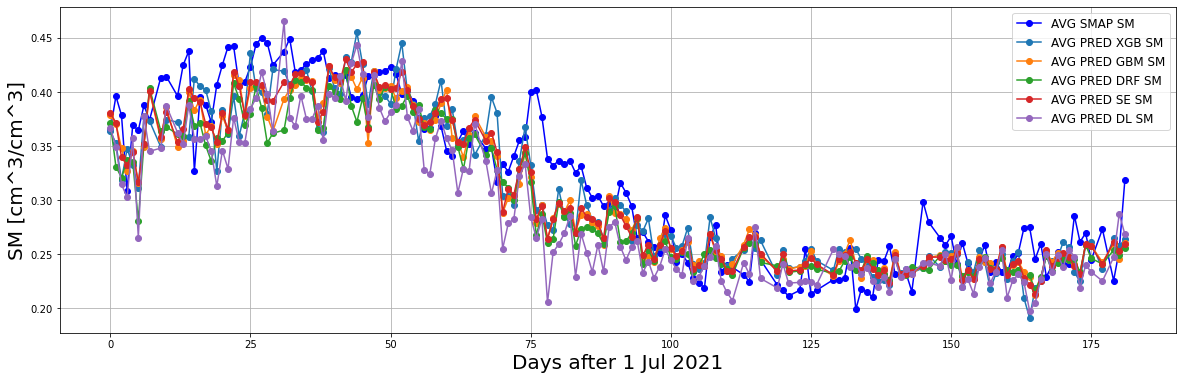

In [128]:
### MADE WITH 10 PARAMETERS ###
### BEST CELL ###

start_day = sm_df['day_of_year'].min()
end_day = 365

days = []
avg_smap_sm_values = []
avg_pred_sm_values_xgboost = []
avg_pred_sm_values_gbm = []
avg_pred_sm_values_drf = []
avg_pred_sm_values_stacked = []
avg_pred_sm_values_dl = []

for i in range(start_day, end_day+1):
    tmp_df = sm_df[sm_df['day_of_year'] == i]
    
    if tmp_df.shape[0] > 0:
        avg_smap = tmp_df['smap_sm'].mean()
        avg_pred_xgboost = tmp_df['predicted_sm_XGBoost'].mean()
        avg_pred_gbm = tmp_df['predicted_sm_GBM'].mean()
        avg_pred_drf = tmp_df['predicted_sm_DRF'].mean()
        avg_pred_stacked = tmp_df['predicted_sm_StackedEnsemble'].mean()
        avg_pred_dl = tmp_df['predicted_sm_DeepLearning'].mean()
        
        days.append(i-start_day)
        avg_smap_sm_values.append(avg_smap)
        avg_pred_sm_values_xgboost.append(avg_pred_xgboost)
        avg_pred_sm_values_gbm.append(avg_pred_gbm)
        avg_pred_sm_values_drf.append(avg_pred_drf)
        avg_pred_sm_values_stacked.append(avg_pred_stacked)
        avg_pred_sm_values_dl.append(avg_pred_dl)

        
fig = plt.figure(figsize=(20, 6))
ax = plt.axes()
ax.grid()
ax.plot(days, avg_smap_sm_values, color='blue', marker="o", label='AVG SMAP SM')
ax.plot(days, avg_pred_sm_values_xgboost, marker="o", label='AVG PRED XGB SM')
ax.plot(days, avg_pred_sm_values_gbm, marker="o", label='AVG PRED GBM SM')
ax.plot(days, avg_pred_sm_values_drf, marker="o", label='AVG PRED DRF SM')
ax.plot(days, avg_pred_sm_values_stacked, marker="o", label='AVG PRED SE SM')
ax.plot(days, avg_pred_sm_values_dl, marker="o", label='AVG PRED DL SM')
ax.set_ylabel("SM [cm^3/cm^3]", fontsize=20)
ax.set_xlabel('Days after ' + str(data_split_date[0]) + ' ' + str(month_abbr[data_split_date[1]]) + ' ' + str(data_split_date[2]), fontsize=20)
ax.set_ylabel('SM [cm^3/cm^3]', fontsize=20)
plt.legend(fontsize='large')
# plt.savefig('/Users/madsrindal/Desktop/Master Plots/AutoML/PredictedTS_10params.png', format='png')
plt.show()


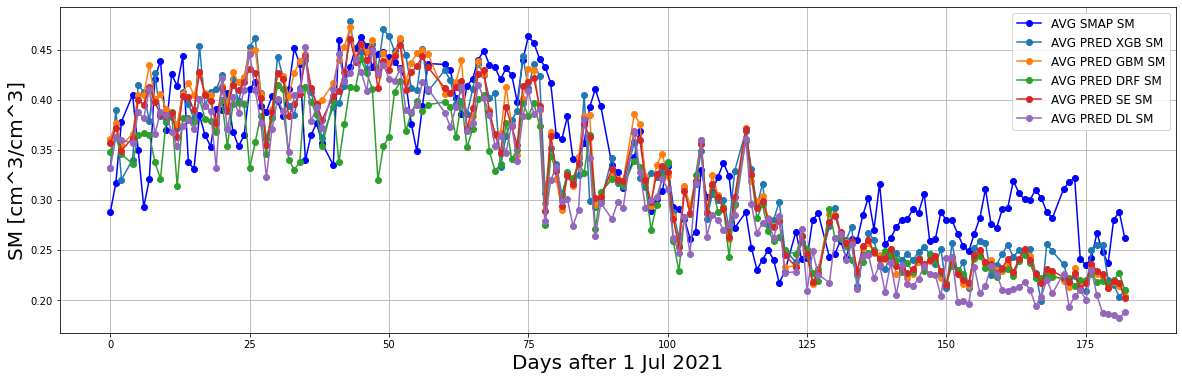

In [60]:
### MADE WITH 10 PARAMETERS ###
### WORST CELL ###

start_day = sm_df['day_of_year'].min()
end_day = 365

days = []
avg_smap_sm_values = []
avg_pred_sm_values_xgboost = []
avg_pred_sm_values_gbm = []
avg_pred_sm_values_drf = []
avg_pred_sm_values_stacked = []
avg_pred_sm_values_dl = []

for i in range(start_day, end_day+1):
    tmp_df = sm_df[sm_df['day_of_year'] == i]
    
    if tmp_df.shape[0] > 0:
        avg_smap = tmp_df['smap_sm'].mean()
        avg_pred_xgboost = tmp_df['predicted_sm_XGBoost'].mean()
        avg_pred_gbm = tmp_df['predicted_sm_GBM'].mean()
        avg_pred_drf = tmp_df['predicted_sm_DRF'].mean()
        avg_pred_stacked = tmp_df['predicted_sm_StackedEnsemble'].mean()
        avg_pred_dl = tmp_df['predicted_sm_DeepLearning'].mean()
        
        days.append(i-start_day)
        avg_smap_sm_values.append(avg_smap)
        avg_pred_sm_values_xgboost.append(avg_pred_xgboost)
        avg_pred_sm_values_gbm.append(avg_pred_gbm)
        avg_pred_sm_values_drf.append(avg_pred_drf)
        avg_pred_sm_values_stacked.append(avg_pred_stacked)
        avg_pred_sm_values_dl.append(avg_pred_dl)

        
fig = plt.figure(figsize=(20, 6))
ax = plt.axes()
ax.grid()
ax.plot(days, avg_smap_sm_values, color='blue', marker="o", label='AVG SMAP SM')
ax.plot(days, avg_pred_sm_values_xgboost, marker="o", label='AVG PRED XGB SM')
ax.plot(days, avg_pred_sm_values_gbm, marker="o", label='AVG PRED GBM SM')
ax.plot(days, avg_pred_sm_values_drf, marker="o", label='AVG PRED DRF SM')
ax.plot(days, avg_pred_sm_values_stacked, marker="o", label='AVG PRED SE SM')
ax.plot(days, avg_pred_sm_values_dl, marker="o", label='AVG PRED DL SM')
ax.set_ylabel("SM [cm^3/cm^3]", fontsize=20)
ax.set_xlabel('Days after ' + str(data_split_date[0]) + ' ' + str(month_abbr[data_split_date[1]]) + ' ' + str(data_split_date[2]), fontsize=20)
ax.set_ylabel('SM [cm^3/cm^3]', fontsize=20)
plt.legend(fontsize='large')
# plt.savefig('/Users/madsrindal/Desktop/Master Plots/AutoML/PredictedTS_10params.png', format='png')
plt.show()


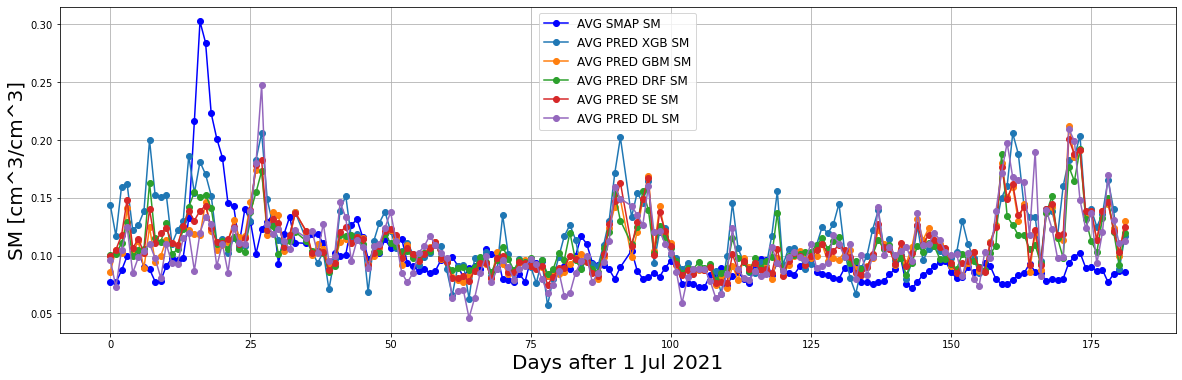

In [221]:
### MADE WITH 10 PARAMETERS ###
### BEST CELL ###
### IRAN ###

start_day = sm_df['day_of_year'].min()
end_day = 365

days = []
avg_smap_sm_values = []
avg_pred_sm_values_xgboost = []
avg_pred_sm_values_gbm = []
avg_pred_sm_values_drf = []
avg_pred_sm_values_stacked = []
avg_pred_sm_values_dl = []

for i in range(start_day, end_day+1):
    tmp_df = sm_df[sm_df['day_of_year'] == i]
    
    if tmp_df.shape[0] > 0:
        avg_smap = tmp_df['smap_sm'].mean()
        avg_pred_xgboost = tmp_df['predicted_sm_XGBoost'].mean()
        avg_pred_gbm = tmp_df['predicted_sm_GBM'].mean()
        avg_pred_drf = tmp_df['predicted_sm_DRF'].mean()
        avg_pred_stacked = tmp_df['predicted_sm_StackedEnsemble'].mean()
        avg_pred_dl = tmp_df['predicted_sm_DeepLearning'].mean()
        
        days.append(i-start_day)
        avg_smap_sm_values.append(avg_smap)
        avg_pred_sm_values_xgboost.append(avg_pred_xgboost)
        avg_pred_sm_values_gbm.append(avg_pred_gbm)
        avg_pred_sm_values_drf.append(avg_pred_drf)
        avg_pred_sm_values_stacked.append(avg_pred_stacked)
        avg_pred_sm_values_dl.append(avg_pred_dl)

        
fig = plt.figure(figsize=(20, 6))
ax = plt.axes()
ax.grid()
ax.plot(days, avg_smap_sm_values, color='blue', marker="o", label='AVG SMAP SM')
ax.plot(days, avg_pred_sm_values_xgboost, marker="o", label='AVG PRED XGB SM')
ax.plot(days, avg_pred_sm_values_gbm, marker="o", label='AVG PRED GBM SM')
ax.plot(days, avg_pred_sm_values_drf, marker="o", label='AVG PRED DRF SM')
ax.plot(days, avg_pred_sm_values_stacked, marker="o", label='AVG PRED SE SM')
ax.plot(days, avg_pred_sm_values_dl, marker="o", label='AVG PRED DL SM')
ax.set_ylabel("SM [cm^3/cm^3]", fontsize=20)
ax.set_xlabel('Days after ' + str(data_split_date[0]) + ' ' + str(month_abbr[data_split_date[1]]) + ' ' + str(data_split_date[2]), fontsize=20)
ax.set_ylabel('SM [cm^3/cm^3]', fontsize=20)
plt.legend(fontsize='large')
# plt.savefig('/Users/madsrindal/Desktop/Master Plots/AutoML/PredictedTS_10params_Iran.png', format='png')
plt.show()


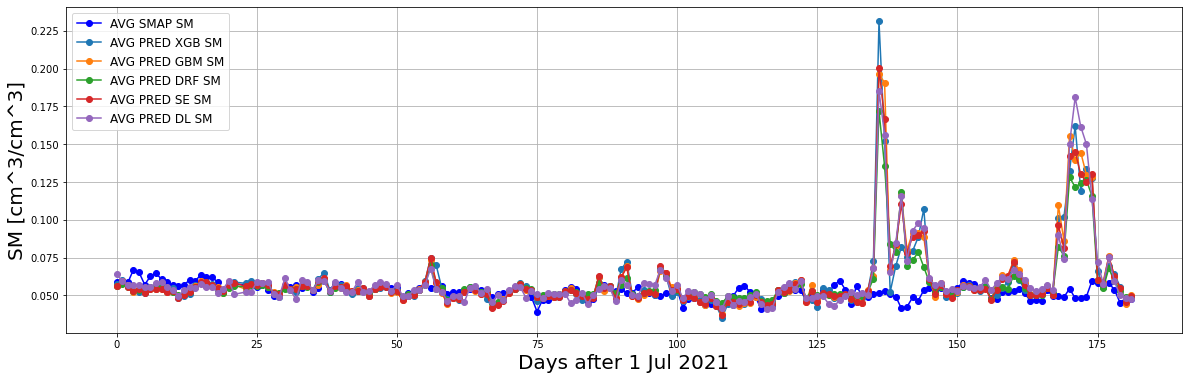

In [297]:
### MADE WITH 10 PARAMETERS ###
### WORST CELL ###
### IRAN ###

start_day = sm_df['day_of_year'].min()
end_day = 365

days = []
avg_smap_sm_values = []
avg_pred_sm_values_xgboost = []
avg_pred_sm_values_gbm = []
avg_pred_sm_values_drf = []
avg_pred_sm_values_stacked = []
avg_pred_sm_values_dl = []

for i in range(start_day, end_day+1):
    tmp_df = sm_df[sm_df['day_of_year'] == i]
    
    if tmp_df.shape[0] > 0:
        avg_smap = tmp_df['smap_sm'].mean()
        avg_pred_xgboost = tmp_df['predicted_sm_XGBoost'].mean()
        avg_pred_gbm = tmp_df['predicted_sm_GBM'].mean()
        avg_pred_drf = tmp_df['predicted_sm_DRF'].mean()
        avg_pred_stacked = tmp_df['predicted_sm_StackedEnsemble'].mean()
        avg_pred_dl = tmp_df['predicted_sm_DeepLearning'].mean()
        
        days.append(i-start_day)
        avg_smap_sm_values.append(avg_smap)
        avg_pred_sm_values_xgboost.append(avg_pred_xgboost)
        avg_pred_sm_values_gbm.append(avg_pred_gbm)
        avg_pred_sm_values_drf.append(avg_pred_drf)
        avg_pred_sm_values_stacked.append(avg_pred_stacked)
        avg_pred_sm_values_dl.append(avg_pred_dl)

        
fig = plt.figure(figsize=(20, 6))
ax = plt.axes()
ax.grid()
ax.plot(days, avg_smap_sm_values, color='blue', marker="o", label='AVG SMAP SM')
ax.plot(days, avg_pred_sm_values_xgboost, marker="o", label='AVG PRED XGB SM')
ax.plot(days, avg_pred_sm_values_gbm, marker="o", label='AVG PRED GBM SM')
ax.plot(days, avg_pred_sm_values_drf, marker="o", label='AVG PRED DRF SM')
ax.plot(days, avg_pred_sm_values_stacked, marker="o", label='AVG PRED SE SM')
ax.plot(days, avg_pred_sm_values_dl, marker="o", label='AVG PRED DL SM')
ax.set_ylabel("SM [cm^3/cm^3]", fontsize=20)
ax.set_xlabel('Days after ' + str(data_split_date[0]) + ' ' + str(month_abbr[data_split_date[1]]) + ' ' + str(data_split_date[2]), fontsize=20)
ax.set_ylabel('SM [cm^3/cm^3]', fontsize=20)
plt.legend(fontsize='large')
# plt.savefig('/Users/madsrindal/Desktop/Master Plots/AutoML/PredictedTS_10params_Iran_worst.png', format='png')
plt.show()


In [100]:
## MADE WITH 4 PARAMS ##
## BEST CELL ##
print('Correlation XGBOOST: ' + str(round(pd.Series(avg_pred_sm_values_xgboost).corr(pd.Series(avg_smap_sm_values)), 3)))
print('Correlation GBM: ' + str(round(pd.Series(avg_pred_sm_values_gbm).corr(pd.Series(avg_smap_sm_values)), 3)))
print('Correlation DRF: ' + str(round(pd.Series(avg_pred_sm_values_drf).corr(pd.Series(avg_smap_sm_values)), 3)))
print('Correlation STACKED: ' + str(round(pd.Series(avg_pred_sm_values_stacked).corr(pd.Series(avg_smap_sm_values)), 3)))
print('Correlation DL: ' + str(round(pd.Series(avg_pred_sm_values_dl).corr(pd.Series(avg_smap_sm_values)), 3)))
    

Correlation XGBOOST: 0.903
Correlation GBM: 0.905
Correlation DRF: 0.892
Correlation STACKED: 0.907
Correlation DL: 0.855


In [163]:
## MADE WITH 4 PARAMS ##
## WORST CELL ##
print('Correlation XGBOOST: ' + str(round(pd.Series(avg_pred_sm_values_xgboost).corr(pd.Series(avg_smap_sm_values)), 3)))
print('Correlation GBM: ' + str(round(pd.Series(avg_pred_sm_values_gbm).corr(pd.Series(avg_smap_sm_values)), 3)))
print('Correlation DRF: ' + str(round(pd.Series(avg_pred_sm_values_drf).corr(pd.Series(avg_smap_sm_values)), 3)))
print('Correlation STACKED: ' + str(round(pd.Series(avg_pred_sm_values_stacked).corr(pd.Series(avg_smap_sm_values)), 3)))
#print('Correlation DL: ' + str(round(pd.Series(avg_pred_sm_values_dl).corr(pd.Series(avg_smap_sm_values)), 3)))
    

Correlation XGBOOST: 0.769
Correlation GBM: 0.765
Correlation DRF: 0.765
Correlation STACKED: 0.773


In [80]:
## MADE WITH 6 PARAMS ##
## BEST CELL ##
print('Correlation XGBOOST: ' + str(round(pd.Series(avg_pred_sm_values_xgboost).corr(pd.Series(avg_smap_sm_values)), 3)))
print('Correlation GBM: ' + str(round(pd.Series(avg_pred_sm_values_gbm).corr(pd.Series(avg_smap_sm_values)), 3)))
print('Correlation DRF: ' + str(round(pd.Series(avg_pred_sm_values_drf).corr(pd.Series(avg_smap_sm_values)), 3)))
print('Correlation STACKED: ' + str(round(pd.Series(avg_pred_sm_values_stacked).corr(pd.Series(avg_smap_sm_values)), 3)))
#print('Correlation DL: ' + str(round(pd.Series(avg_pred_sm_values_dl).corr(pd.Series(avg_smap_sm_values)), 3)))
    

Correlation XGBOOST: 0.901
Correlation GBM: 0.92
Correlation DRF: 0.903
Correlation STACKED: 0.922


In [107]:
## MADE WITH 8 PARAMS ##
## BEST CELL ##
print('Correlation XGBOOST: ' + str(round(pd.Series(avg_pred_sm_values_xgboost).corr(pd.Series(avg_smap_sm_values)), 3)))
print('Correlation GBM: ' + str(round(pd.Series(avg_pred_sm_values_gbm).corr(pd.Series(avg_smap_sm_values)), 3)))
print('Correlation DRF: ' + str(round(pd.Series(avg_pred_sm_values_drf).corr(pd.Series(avg_smap_sm_values)), 3)))
print('Correlation STACKED: ' + str(round(pd.Series(avg_pred_sm_values_stacked).corr(pd.Series(avg_smap_sm_values)), 3)))
print('Correlation DL: ' + str(round(pd.Series(avg_pred_sm_values_dl).corr(pd.Series(avg_smap_sm_values)), 3)))


Correlation XGBOOST: 0.905
Correlation GBM: 0.924
Correlation DRF: 0.91
Correlation STACKED: 0.926
Correlation DL: 0.889


In [39]:
## MADE WITH 8 PARAMS ##
## WORST CELL ##
print('Correlation XGBOOST: ' + str(round(pd.Series(avg_pred_sm_values_xgboost).corr(pd.Series(avg_smap_sm_values)), 3)))
print('Correlation GBM: ' + str(round(pd.Series(avg_pred_sm_values_gbm).corr(pd.Series(avg_smap_sm_values)), 3)))
print('Correlation DRF: ' + str(round(pd.Series(avg_pred_sm_values_drf).corr(pd.Series(avg_smap_sm_values)), 3)))
print('Correlation STACKED: ' + str(round(pd.Series(avg_pred_sm_values_stacked).corr(pd.Series(avg_smap_sm_values)), 3)))
print('Correlation DL: ' + str(round(pd.Series(avg_pred_sm_values_dl).corr(pd.Series(avg_smap_sm_values)), 3)))


Correlation XGBOOST: 0.809
Correlation GBM: 0.803
Correlation DRF: 0.747
Correlation STACKED: 0.817
Correlation DL: 0.786


In [185]:
## MADE WITH 8 PARAMS ##
## BEST CELL ##
## IRAN ##
print('Correlation XGBOOST: ' + str(round(pd.Series(avg_pred_sm_values_xgboost).corr(pd.Series(avg_smap_sm_values)), 3)))
print('Correlation GBM: ' + str(round(pd.Series(avg_pred_sm_values_gbm).corr(pd.Series(avg_smap_sm_values)), 3)))
print('Correlation DRF: ' + str(round(pd.Series(avg_pred_sm_values_drf).corr(pd.Series(avg_smap_sm_values)), 3)))
print('Correlation STACKED: ' + str(round(pd.Series(avg_pred_sm_values_stacked).corr(pd.Series(avg_smap_sm_values)), 3)))
print('Correlation DL: ' + str(round(pd.Series(avg_pred_sm_values_dl).corr(pd.Series(avg_smap_sm_values)), 3)))


Correlation XGBOOST: 0.234
Correlation GBM: 0.19
Correlation DRF: 0.27
Correlation STACKED: 0.208
Correlation DL: 0.02


In [274]:
## MADE WITH 8 PARAMS ##
## WORST CELL ##
## IRAN ##
print('Correlation XGBOOST: ' + str(round(pd.Series(avg_pred_sm_values_xgboost).corr(pd.Series(avg_smap_sm_values)), 3)))
print('Correlation GBM: ' + str(round(pd.Series(avg_pred_sm_values_gbm).corr(pd.Series(avg_smap_sm_values)), 3)))
print('Correlation DRF: ' + str(round(pd.Series(avg_pred_sm_values_drf).corr(pd.Series(avg_smap_sm_values)), 3)))
print('Correlation STACKED: ' + str(round(pd.Series(avg_pred_sm_values_stacked).corr(pd.Series(avg_smap_sm_values)), 3)))
print('Correlation DL: ' + str(round(pd.Series(avg_pred_sm_values_dl).corr(pd.Series(avg_smap_sm_values)), 3)))


Correlation XGBOOST: 0.063
Correlation GBM: 0.001
Correlation DRF: -0.018
Correlation STACKED: 0.016
Correlation DL: 0.024


In [129]:
## MADE WITH 10 PARAMS ##
## BEST CELL ##
print('Correlation XGBOOST: ' + str(round(pd.Series(avg_pred_sm_values_xgboost).corr(pd.Series(avg_smap_sm_values)), 3)))
print('Correlation GBM: ' + str(round(pd.Series(avg_pred_sm_values_gbm).corr(pd.Series(avg_smap_sm_values)), 3)))
print('Correlation DRF: ' + str(round(pd.Series(avg_pred_sm_values_drf).corr(pd.Series(avg_smap_sm_values)), 3)))
print('Correlation STACKED: ' + str(round(pd.Series(avg_pred_sm_values_stacked).corr(pd.Series(avg_smap_sm_values)), 3)))
print('Correlation DL: ' + str(round(pd.Series(avg_pred_sm_values_dl).corr(pd.Series(avg_smap_sm_values)), 3)))


Correlation XGBOOST: 0.897
Correlation GBM: 0.922
Correlation DRF: 0.916
Correlation STACKED: 0.923
Correlation DL: 0.889


In [61]:
## MADE WITH 10 PARAMS ##
## WORST CELL ##
print('Correlation XGBOOST: ' + str(round(pd.Series(avg_pred_sm_values_xgboost).corr(pd.Series(avg_smap_sm_values)), 3)))
print('Correlation GBM: ' + str(round(pd.Series(avg_pred_sm_values_gbm).corr(pd.Series(avg_smap_sm_values)), 3)))
print('Correlation DRF: ' + str(round(pd.Series(avg_pred_sm_values_drf).corr(pd.Series(avg_smap_sm_values)), 3)))
print('Correlation STACKED: ' + str(round(pd.Series(avg_pred_sm_values_stacked).corr(pd.Series(avg_smap_sm_values)), 3)))
print('Correlation DL: ' + str(round(pd.Series(avg_pred_sm_values_dl).corr(pd.Series(avg_smap_sm_values)), 3)))


Correlation XGBOOST: 0.815
Correlation GBM: 0.815
Correlation DRF: 0.767
Correlation STACKED: 0.817
Correlation DL: 0.809


In [222]:
## MADE WITH 10 PARAMS ##
## BEST CELL ##
## IRAN ##
print('Correlation XGBOOST: ' + str(round(pd.Series(avg_pred_sm_values_xgboost).corr(pd.Series(avg_smap_sm_values)), 3)))
print('Correlation GBM: ' + str(round(pd.Series(avg_pred_sm_values_gbm).corr(pd.Series(avg_smap_sm_values)), 3)))
print('Correlation DRF: ' + str(round(pd.Series(avg_pred_sm_values_drf).corr(pd.Series(avg_smap_sm_values)), 3)))
print('Correlation STACKED: ' + str(round(pd.Series(avg_pred_sm_values_stacked).corr(pd.Series(avg_smap_sm_values)), 3)))
print('Correlation DL: ' + str(round(pd.Series(avg_pred_sm_values_dl).corr(pd.Series(avg_smap_sm_values)), 3)))


Correlation XGBOOST: 0.216
Correlation GBM: 0.174
Correlation DRF: 0.307
Correlation STACKED: 0.206
Correlation DL: 0.096


In [298]:
## MADE WITH 10 PARAMS ##
## WORST CELL ##
## IRAN ##
print('Correlation XGBOOST: ' + str(round(pd.Series(avg_pred_sm_values_xgboost).corr(pd.Series(avg_smap_sm_values)), 3)))
print('Correlation GBM: ' + str(round(pd.Series(avg_pred_sm_values_gbm).corr(pd.Series(avg_smap_sm_values)), 3)))
print('Correlation DRF: ' + str(round(pd.Series(avg_pred_sm_values_drf).corr(pd.Series(avg_smap_sm_values)), 3)))
print('Correlation STACKED: ' + str(round(pd.Series(avg_pred_sm_values_stacked).corr(pd.Series(avg_smap_sm_values)), 3)))
print('Correlation DL: ' + str(round(pd.Series(avg_pred_sm_values_dl).corr(pd.Series(avg_smap_sm_values)), 3)))


Correlation XGBOOST: 0.027
Correlation GBM: -0.012
Correlation DRF: -0.019
Correlation STACKED: 0.003
Correlation DL: -0.035


In [ ]:
## MOSTAFA PLOTTING ##

In [300]:
mostafa_df = india_df.copy()

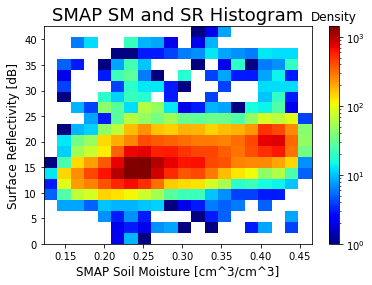

In [301]:
from matplotlib.colors import LogNorm

hist = plt.hist2d(mostafa_df['smap_sm'], mostafa_df['sr'], (20, 20), cmap=plt.cm.jet, norm=LogNorm(), cmin=1)
plt.title('SMAP SM and SR Histogram', fontsize=18)
plt.ylabel('Surface Reflectivity [dB]', fontsize=12)
plt.xlabel('SMAP Soil Moisture [cm^3/cm^3]', fontsize=12)
bar = plt.colorbar()
bar.ax.set_title('Density')
# plt.savefig('/Users/madsrindal/Desktop/Plots/smap_sm_and_sr_density_histogram.png')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

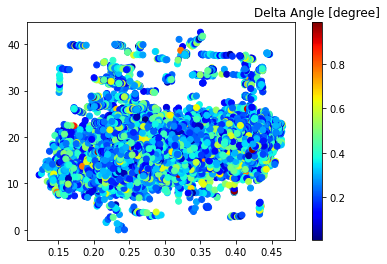

In [306]:
plt.scatter(mostafa_df['smap_sm'], mostafa_df['sr'], c=mostafa_df['delta_angle'], cmap='jet')
bar = plt.colorbar()
bar.ax.set_title('Delta Angle [degree]')
plt.show

In [307]:
print(india_df['sp_lat'].min())
print(india_df['sp_lat'].max())

21.000062942504883
21.499998092651367


<function matplotlib.pyplot.show(close=None, block=None)>

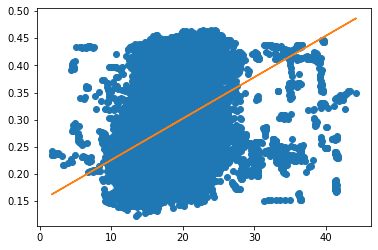

In [23]:
plt.plot(mostafa_df['sr'], mostafa_df['smap_sm'], marker='o', linewidth=0)
m, b = np. polyfit(mostafa_df['sr'], mostafa_df['smap_sm'], 1)
plt. plot(mostafa_df['sr'], m*mostafa_df['sr'] + b) 
plt.show

In [ ]:
print('Correlation Best Part India: ' + str(round(mostafa_df['sr'].corr(mostafa_df['smap_sm']), 3)))

In [35]:
nn_interpolated_df = pd.read_csv('/Users/madsrindal/Desktop/Natural Neighbour/India/Best Cell/nn_interpolated_df_smap_sm.csv')


In [27]:
nn_interpolated_df['day_of_year'] = nn_interpolated_df['time'].progress_apply(lambda x: math.ceil(x/24))

100%|██████████| 40192/40192 [00:00<00:00, 605822.81it/s]


In [36]:
nn_interpolated_df.head()

,lat,long,time,smap_sm
0,20.5,81.0,12,0.291413
1,20.5,81.0,180,0.291413
2,20.5,81.0,348,0.291413
3,20.5,81.0,516,0.291413
4,20.5,81.0,684,0.291413


In [37]:
nn_interpolated_df['smap_sm'].unique()

array([0.29141334])

In [30]:
import numpy as np
import pandas as pd

import time
import pickle

from tqdm import tqdm
tqdm.pandas()

import naturalneighbor


def filter_cygnss_qf(df):
    remove_mask = int('11000000010011010', 2)
    return df[df['quality_flags'] & remove_mask == 0]


def filter_smap_qfs(smap_df):
    return smap_df.loc[(smap_df['retrieval_qfs'] == 0) | (smap_df['retrieval_qfs'] == 8)]


def get_hours_after_jan_2019(old_hours, year):
    if year == 2019:
        return old_hours
    elif year == 2020:
        return old_hours + 24*365
    else:
        return old_hours + 24*365 + 24*366 # 366 fordi 2020 var skuddår


def fix_hours_after_jan_2019(df):
    df['hours_after_jan_2019'] = df.progress_apply(
        lambda row: get_hours_after_jan_2019(row.hours_after_jan_2020, row.year), axis=1)
    return df


def filter_location(df, location, cygnss=True):
    if cygnss:
        filtered_df = df[df.sp_lat < location[0]]
        filtered_df = filtered_df[filtered_df.sp_lat > location[2]]
        filtered_df = filtered_df[filtered_df.sp_lon < location[3]]
        filtered_df = filtered_df[filtered_df.sp_lon > location[1]]
    else:
        filtered_df = df[df.lat < location[0]]
        filtered_df = filtered_df[filtered_df.lat > location[2]]
        filtered_df = filtered_df[filtered_df.long < location[3]]
        filtered_df = filtered_df[filtered_df.long > location[1]]
    
    return filtered_df



# INDIA USED FOR TESTING
location = '24-80-19-85'
small_pixel_worst = [20, 83.5, 19.5, 84]
small_pixel_best = [21.5, 81.5, 21, 82]

pixel_loc_worst = [20.5, 83, 19, 84.5]
pixel_loc_best = [22, 81, 20.5, 82.5]



### Load CYGNSS ###
cygnss_df = pd.DataFrame()

for year in range(2019, 2022):
    retrieval_path = '/Users/madsrindal/Desktop/Intervals/' + location + '/'
    file_name = 'CYGNSS' + str(year) + '-withQFs-[' + location + '].csv'
    tmp_df = pd.read_csv(retrieval_path + file_name)
    
    # Adding column for year
    tmp_df['year'] = year
    
    shape_before = tmp_df.shape[0]
    tmp_df = filter_cygnss_qf(tmp_df)
    print('Removed ' + str(shape_before - tmp_df.shape[0]) + ' rows of bad CYGNSS data from ' + str(year) + '...')
    cygnss_df = cygnss_df.append(tmp_df, ignore_index=True)

# Fix hours_after_jan_2019 column
cygnss_df = fix_hours_after_jan_2019(cygnss_df)

# Remove unused CYGNSS parameters
cygnss_cols_to_drop = ['ddm_channel', 'ddm_timestamp_utc', 'rx_to_sp_range', 'tx_to_sp_range', 
                       'quality_flags', 'quality_flags_2', 'hours_after_jan_2020']
cygnss_df = cygnss_df.drop(columns=cygnss_cols_to_drop)



### Load SMAP ###
retrieval_path = '/Users/madsrindal/Desktop/Intervals/' + location + '/'
file_name = 'SMAP-allYears-withQFs-[' + location + '].csv'
smap_df = pd.read_csv(retrieval_path + file_name)
shape_before = smap_df.shape[0]
smap_df = filter_smap_qfs(smap_df)
print('Removed ' + str(shape_before - smap_df.shape[0]) + ' rows of bad SMAP data...')

# Remove unused SMAP parameters
smap_cols_to_drop = ['retrieval_qfs', 'surface_temp', 'vegetation_water_content', 'landcover_class_01', 'landcover_class_02', 'landcover_class_03']
smap_df = smap_df.drop(columns=smap_cols_to_drop)

# Filter data based on pixel location
cygnss_pxl_df = filter_location(cygnss_df, pixel_loc_best, True)
smap_pxl_df = filter_location(smap_df, pixel_loc_best, False)



### Natural Neighbour Interpolation ###
def nn_interpolation(smap_pxl_df, grid_ranges, target_value='smap_sm'):
    points = np.array(list(map(list, zip(list(smap_pxl_df['time']), list(smap_pxl_df['lat']), list(smap_pxl_df['long'])))))
    values = np.array(list(smap_pxl_df[target_value]))
    nn_interpolated_values = naturalneighbor.griddata(points, values, grid_ranges)
    return nn_interpolated_values


def create_df_from_3d_array(interpolated_array, grid_ranges, target_value='smap_sm'):
    lat_min = grid_ranges[0][0]
    lat_max = grid_ranges[0][1]
    lat_complex = int(str(grid_ranges[0][2])[:-1])
    lat_step = (lat_max-lat_min) / (lat_complex-1)

    long_min = grid_ranges[1][0]
    long_max = grid_ranges[1][1]
    long_complex = int(str(grid_ranges[1][2])[:-1])
    long_step = (long_max-long_min) / (long_complex-1)

    time_min = grid_ranges[2][0]
    time_max = grid_ranges[2][1]
    time_step = grid_ranges[2][2]
    
    lats = []
    longs = []
    times = []
    values = list(interpolated_array.flatten())

    for i in range(lat_complex):
        lat = lat_min + (i*lat_step)

        for j in range(long_complex):
            long = long_min + (j*long_step)

            for k in range(time_min, time_max, time_step):

                lats.append(lat)
                longs.append(long)
                times.append(k)

    df = pd.DataFrame()
    df['lat'] = lats
    df['long'] = longs
    df['time'] = times
    df[target_value] = values
    return df
    

Removed 55835 rows of bad CYGNSS data from 2019...
Removed 114134 rows of bad CYGNSS data from 2020...
Removed 196226 rows of bad CYGNSS data from 2021...


100%|██████████| 4023263/4023263 [01:22<00:00, 48868.15it/s]


Removed 27382 rows of bad SMAP data...


In [31]:
smap_pxl_df.head()

,lat,long,time,smap_sm,surface_roughness,vegetation_opacity
76,21.836075,81.224070,19800.994444,0.151035,0.357101,0.377059
77,21.836075,81.597510,19800.994167,0.181077,0.342253,0.254288
78,21.836075,81.970955,19800.993889,0.198334,0.460841,0.165945
79,21.836075,82.344400,19800.993333,0.191045,0.592449,0.138573
86,21.532677,81.224070,19800.995556,0.165226,0.464942,0.279933


In [34]:
# Set grid ranges to obtain a SM value each 1km lat and long per day
# grid_ranges = [[20.5, 22, 165j], [81, 82.5, 165j], [12, 26316, 24]] # One value per 1km lat and long + each day
grid_ranges = [[20.5, 22, 33j], [81, 82.5, 33j], [12, 26316, 168]] # One value per 5km lat and long + each 7 days
storage_path = '/Users/madsrindal/Desktop/Natural Neighbour/India/Best Cell/'

### Create interpolated 3D grid with Soil Moisture values ###
start = time.time()
target = 'smap_sm'
nn_interpolated_sm = nn_interpolation(smap_pxl_df, grid_ranges, target_value=target)
print('Finished natural neighbour interpolation with smap_sm as the target value in ' + str(time.time()-start) + ' seconds...')

# Store the raw array as a pickle file
output = open(storage_path + target + '_raw_array.pkl', 'wb')
pickle.dump(nn_interpolated_sm, output)
output.close()

# Store results as a data frame
sm_df = create_df_from_3d_array(nn_interpolated_sm, grid_ranges, target_value=target)
file_name = 'nn_interpolated_df_' + target + '.csv'
sm_df.to_csv(storage_path + file_name, index=False)
print('Successfully stored the results...')


"""
### Create interpolated 3D grid with Vegetation Opacity values ###
start = time.time()
target = 'vegetation_opacity'
nn_interpolated_vo = nn_interpolation(smap_pxl_df, grid_ranges, target_value=target)
print('Finished natural neighbour interpolation with vegetation_opacity as the target value in ' + str(time.time()-start) + ' seconds...')

# Store the raw array as a pickle file
output = open(storage_path + target + '_raw_array.pkl', 'wb')
pickle.dump(nn_interpolated_vo, output)
output.close()

# Store results as a data frame
sm_df = create_df_from_3d_array(nn_interpolated_vo, grid_ranges, target_value=target)
file_name = 'nn_interpolated_df_' + target + '.csv'
sm_df.to_csv(storage_path + file_name, index=False)
print('Successfully stored the results...')



### Create interpolated 3D grid with Surface Roughness values ###
start = time.time()
target = 'surface_roughness'
nn_interpolated_sr = nn_interpolation(smap_pxl_df, grid_ranges, target_value=target)
print('Finished natural neighbour interpolation with surface_roughness as the target value in ' + str(time.time()-start) + ' seconds...')

# Store the raw array as a pickle file
output = open(storage_path + target + '_raw_array.pkl', 'wb')
pickle.dump(nn_interpolated_sr, output)
output.close()

# Store results as a data frame
sm_df = create_df_from_3d_array(nn_interpolated_sr, grid_ranges, target_value=target)
file_name = 'nn_interpolated_df_' + target + '.csv'
sm_df.to_csv(storage_path + file_name, index=False)
print('Successfully stored the results...')"""


Finished natural neighbour interpolation with smap_sm as the target value in 42.26169967651367 seconds...
Successfully stored the results...


"\n### Create interpolated 3D grid with Vegetation Opacity values ###\nstart = time.time()\ntarget = 'vegetation_opacity'\nnn_interpolated_vo = nn_interpolation(smap_pxl_df, grid_ranges, target_value=target)\nprint('Finished natural neighbour interpolation with vegetation_opacity as the target value in ' + str(time.time()-start) + ' seconds...')\n\n# Store the raw array as a pickle file\noutput = open(storage_path + target + '_raw_array.pkl', 'wb')\npickle.dump(nn_interpolated_vo, output)\noutput.close()\n\n# Store results as a data frame\nsm_df = create_df_from_3d_array(nn_interpolated_vo, grid_ranges, target_value=target)\nfile_name = 'nn_interpolated_df_' + target + '.csv'\nsm_df.to_csv(storage_path + file_name, index=False)\nprint('Successfully stored the results...')\n\n\n\n### Create interpolated 3D grid with Surface Roughness values ###\nstart = time.time()\ntarget = 'surface_roughness'\nnn_interpolated_sr = nn_interpolation(smap_pxl_df, grid_ranges, target_value=target)\nprint(